## Airline Passenger Prediction - Time Series Analysis

This notebook walks through an end-to-end time series forecasting workflow on the classic **AirPassengers** dataset.

**Business objective**  
Forecast monthly international airline passenger demand so an airline can plan **capacity, pricing, and staffing** around future demand levels.

**Data**  
- Monthly passenger counts from **Jan 1949 – Dec 1960** (`AirPassengers.csv`).
- Single target variable: `#Passengers`.

**Modeling steps covered**  
1. Load and inspect the time series.  
2. Visualize trend and seasonality.  
3. Check stationarity (rolling statistics + Dickey–Fuller).  
4. Apply transformations (log) and differencing.  
5. Decompose into trend / seasonality / residuals.  
6. Use ACF/PACF to guide **AR/MA/ARIMA** model choice.  
7. Compare models using **RSS** and residual diagnostics.  
8. Generate and interpret a **10‑year forecast**.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10,6

In [ ]:
dataset = pd.read_csv('data/AirPassengers.csv')
# Parse strings to datetime type
dataset['Month'] = pd.to_datetime(dataset['Month'], infer_datetime_format=True)
indexedDataset = dataset.set_index(['Month'])

In [3]:
from datetime import datetime
indexedDataset.head(5)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


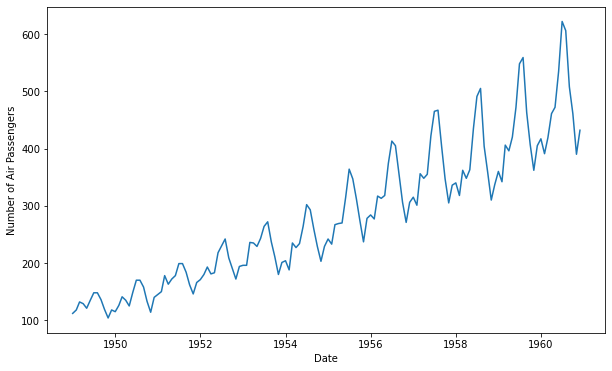

In [4]:
# Plot graph
plt.xlabel('Date')
plt.ylabel('Number of Air Passengers')
plt.plot(indexedDataset)

* We have an upward trend and seasonality. The data is not stationary.


In [5]:
# Determining rolling statistics
rolmean = indexedDataset.rolling(window=12).mean()

rolstd = indexedDataset.rolling(window=12).std()
print(rolmean, rolstd)

            #Passengers
Month                  
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
...                 ...
1960-08-01   463.333333
1960-09-01   467.083333
1960-10-01   471.583333
1960-11-01   473.916667
1960-12-01   476.166667

[144 rows x 1 columns]             #Passengers
Month                  
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
...                 ...
1960-08-01    83.630500
1960-09-01    84.617276
1960-10-01    82.541954
1960-11-01    79.502382
1960-12-01    77.737125

[144 rows x 1 columns]


* We are focusing on a **12‑month rolling window** to capture annual patterns.  
* The first 11 rows are NaN because a full 12 months of data is required before the first rolling statistic can be computed.  
* Comparing the rolling mean and rolling standard deviation over time gives a **visual diagnostic of stationarity**: if they drift, the process is likely non‑stationary.

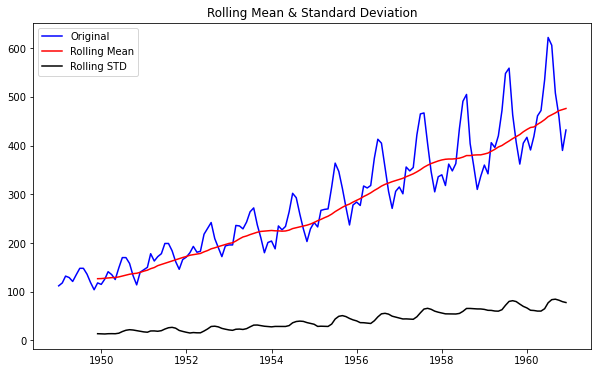

In [6]:
# Plot rolling statistics
orig = plt.plot(indexedDataset, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling STD')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

* The **rolling mean** is clearly increasing over time and the **rolling standard deviation** is not constant.  
* This indicates the series is **non‑stationary** (its distribution changes over time), which violates the assumptions of many classical time series models.  
* We will therefore apply transformations and differencing to move towards stationarity before fitting ARIMA models.

In [7]:
# Performing Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

print('Results of Dickey-Fuller Test: ')
dftest = adfuller(indexedDataset['#Passengers'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistics', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey-Fuller Test: 
Test Statistics                  0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


* The Augmented Dickey–Fuller test reports a **large p‑value (~0.99)** and a test statistic that is **higher than all critical values**.  
* This means we **fail to reject** the null hypothesis of a unit root: the series is **non‑stationary**.  
* This statistically confirms what we saw visually from the rolling mean and standard deviation plots.

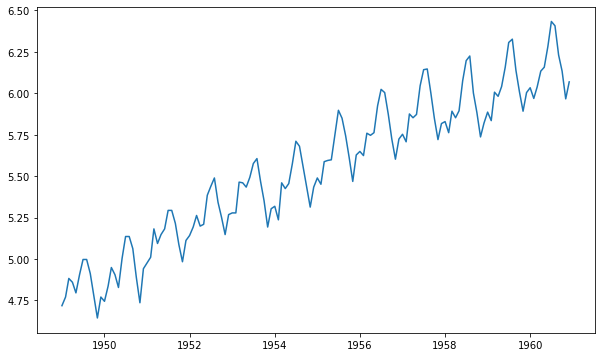

In [8]:
# Estimating trend
indexedDataset_logscale = np.log(indexedDataset)
plt.plot(indexedDataset_logscale)

* We will take a log of the dataset, the y axis has changed but the trend remains the same.

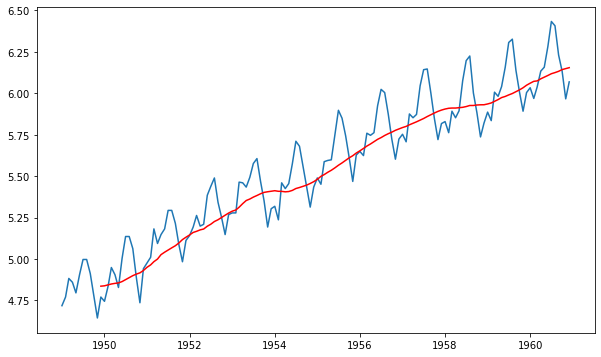

In [9]:
# Calculating the moving average
moving_average = indexedDataset_logscale.rolling(window=12).mean()
moving_std = indexedDataset_logscale.rolling(window=12).std()
plt.plot(indexedDataset_logscale)
plt.plot(moving_average, color='red')

* Taking the moving average in the log timeseries: The mean is not stationary but getting better, moving with the time.

In [10]:
# Get the difference between the moving average and actual number of passengers
dataset_logscale_minus_moving_avg = indexedDataset_logscale - moving_average
dataset_logscale_minus_moving_avg.head(12)

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
1949-06-01,NaN
1949-07-01,NaN
1949-08-01,NaN
1949-09-01,NaN


In [11]:
# Remove NaN values
dataset_logscale_minus_moving_avg.dropna(inplace=True)
dataset_logscale_minus_moving_avg.head(10)

,#Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142
1950-05-01,-0.027529
1950-06-01,0.139881
1950-07-01,0.260184
1950-08-01,0.248635


In [12]:
# Creating a function to determine if the timeseries is stationary or not.
from statsmodels.tsa.stattools import adfuller
def test_stationary(timeseries):
    
    # Determining rolling statistics
    moving_avg = timeseries.rolling(window=12).mean()
    moving_std = timeseries.rolling(window=12).std()
    
    # PLot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(moving_avg, color='red', label='Rolling Mean')
    std = plt.plot(moving_std, color='black', label='Rolling STD')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries['#Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistics', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

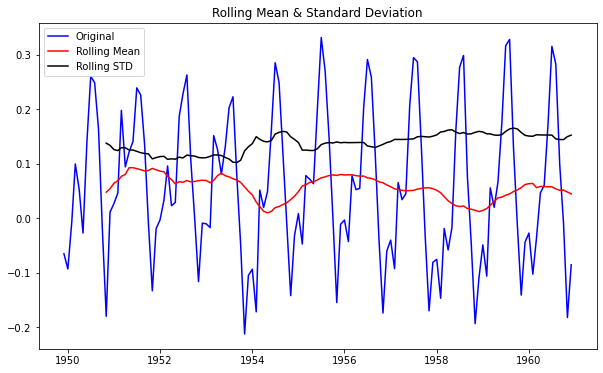

Results of Dickey-Fuller Test:
Test Statistics                 -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [13]:
test_stationary(dataset_logscale_minus_moving_avg)

* After getting the difference between the moving average and actual number of passengers, we can see that the trend is gone and it looks much better than before.
* p value is also relatively less compared to before observations.
* test statistics and cricital value is almost the same: which tells us that the data is now stationary.

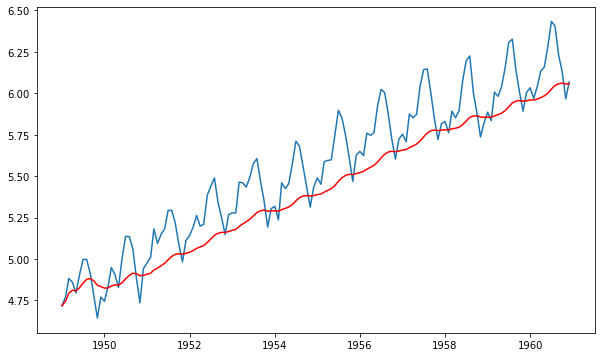

In [14]:
# Calculate the weighted avegare of the timeseries
exponential_decay_weighted_avg = indexedDataset_logscale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logscale)
plt.plot(exponential_decay_weighted_avg, color='red')

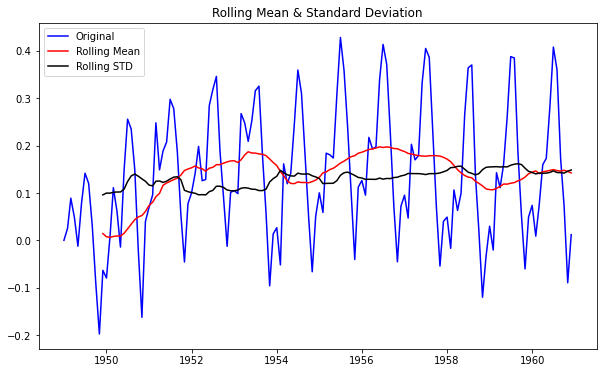

Results of Dickey-Fuller Test:
Test Statistics                 -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [15]:
# Subtracting the weighted average from logscale
dataset_logscale_minus_moving_exponential_decay_avg = indexedDataset_logscale - exponential_decay_weighted_avg
test_stationary(dataset_logscale_minus_moving_exponential_decay_avg)

* std is quite flat
* Rolling mean is better than previous observation.
* p value is very low and the data is stationary.

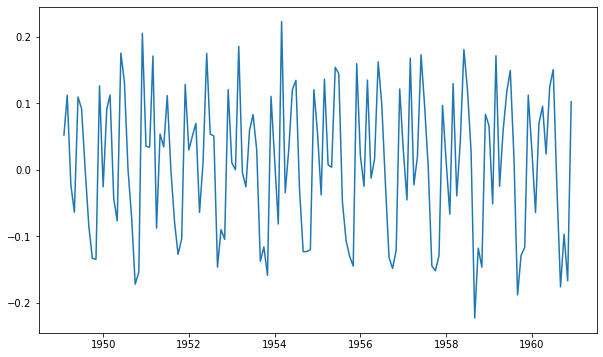

In [16]:
# Shift the values in the timeseries to use in the forecasting
dataset_log_diff_shifting = indexedDataset_logscale - indexedDataset_logscale.shift()
plt.plot(dataset_log_diff_shifting)

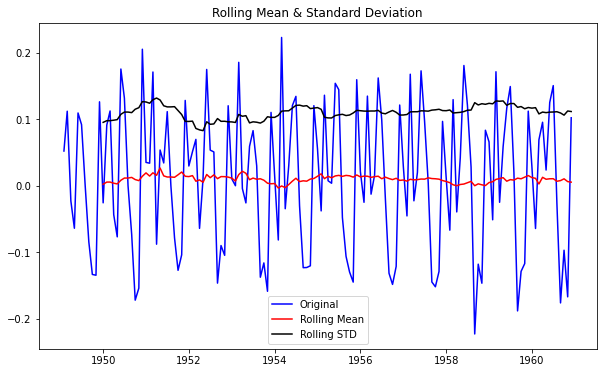

Results of Dickey-Fuller Test:
Test Statistics                 -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [17]:
# Dropping the NaN values
dataset_log_diff_shifting.dropna(inplace=True)
test_stationary(dataset_log_diff_shifting)

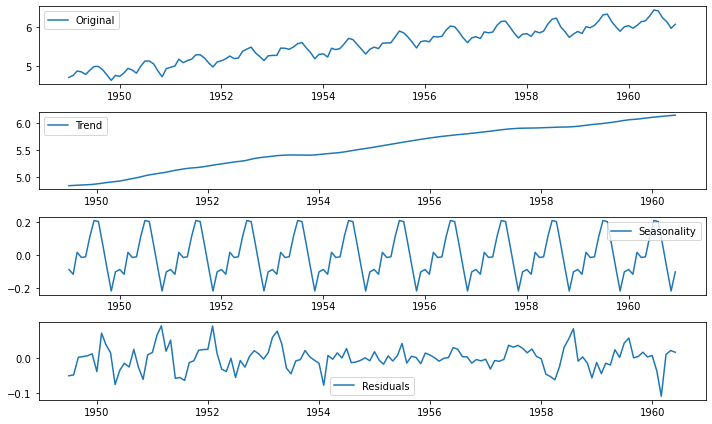

In [18]:
# components of timeseries
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(indexedDataset_logscale)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset_logscale, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


In [19]:
# (Optional) Stationarity check on residuals
# If desired, we could test the decomposed residual component for stationarity:
# decomposed_log_data = residual
# decomposed_log_data.dropna(inplace=True)
# test_stationary(decomposed_log_data)
#
# In an ideal decomposition, the **residuals** should look approximately
# stationary (no clear trend/seasonality), which makes them suitable for
# ARMA/ARIMA modeling.

### ACF & PACF Plot

We use the **Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** on the transformed and differenced series to guide ARIMA order selection:

- ACF helps identify a reasonable value for **q** (MA order).  
- PACF helps identify a reasonable value for **p** (AR order).  

By inspecting where the ACF/PACF cut off or decay, we can narrow down candidate `(p, d, q)` combinations before fitting full ARIMA models.

C:\Users\ivdin\OneDrive\Desktop\data_tuts\env\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


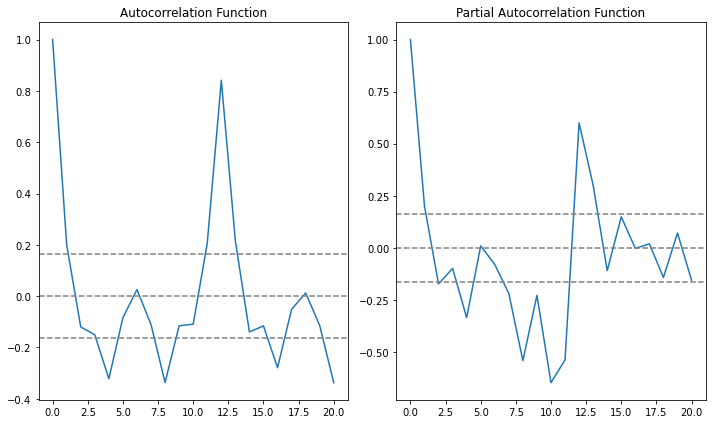

In [20]:
# ACF & PACF Plot
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(dataset_log_diff_shifting, nlags=20)
lag_pacf = pacf(dataset_log_diff_shifting, nlags=20, method='ols')

# Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dataset_log_diff_shifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(dataset_log_diff_shifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

# Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dataset_log_diff_shifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(dataset_log_diff_shifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

* We can calculate the p by looking at PACF figure on the right where the graph line hits the 0.
* Same way we can calculate q by looking at the ACF line plot where the line hits 0.

C:\Users\ivdin\OneDrive\Desktop\data_tuts\env\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\ivdin\OneDrive\Desktop\data_tuts\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

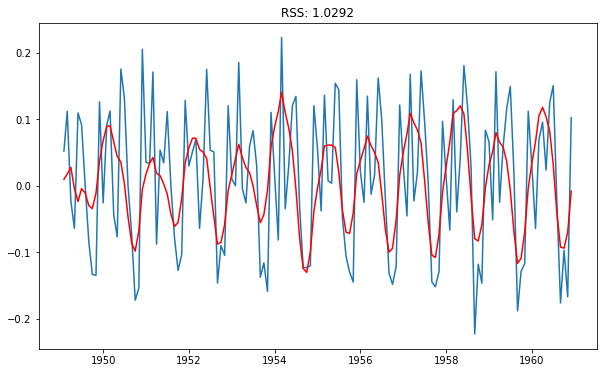

In [21]:
# ARIMA Model
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(indexedDataset_logscale, order=(2,1,2))
results_AR = model.fit(disp=-1)
plt.plot(dataset_log_diff_shifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues-dataset_log_diff_shifting['#Passengers'])**2))
print('Plotting AR Model')


C:\Users\ivdin\OneDrive\Desktop\data_tuts\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ivdin\OneDrive\Desktop\data_tuts\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ivdin\OneDrive\Desktop\data_tuts\env\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue

Plotting ARIMA model


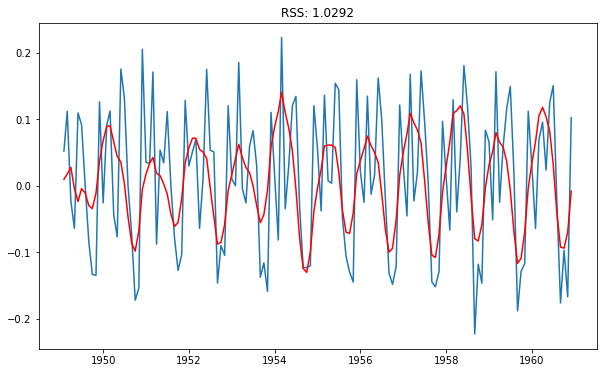

In [23]:
# ARIMA (combined AR + MA model)
# This model allows both autoregressive (AR) and moving average (MA)
# components on the differenced log series. In practice we compare the
# RSS from this ARIMA(2,1,2) model to the simpler AR and MA models.
# A lower RSS indicates a better in-sample fit.
model = ARIMA(indexedDataset_logscale, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(dataset_log_diff_shifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - dataset_log_diff_shifting['#Passengers'])**2))
print('Plotting ARIMA model')

In [24]:
# Predictions
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64


In [25]:
# Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64


In [26]:
predictions_ARIMA_log = pd.Series(indexedDataset_logscale['#Passengers'].iloc[0], index=indexedDataset_logscale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

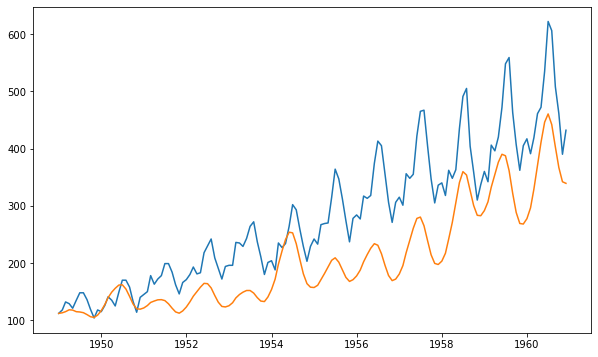

In [27]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(indexedDataset)
plt.plot(predictions_ARIMA)

* We can see that our prediction shape has been captured properly.

In [28]:
indexedDataset_logscale

,#Passengers
Month,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791
...,...
1960-08-01,6.406880
1960-09-01,6.230481
1960-10-01,6.133398


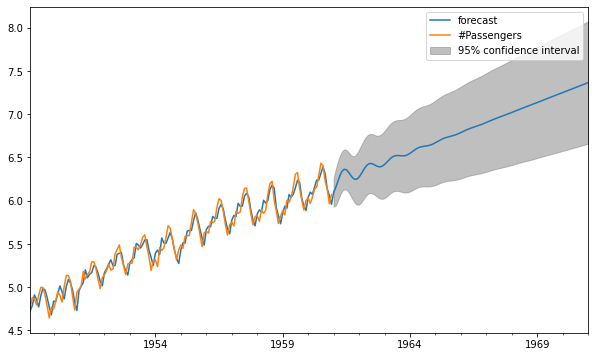

In [29]:
# Predicting for the next 10 years
results_ARIMA.plot_predict(1,264)
x = results_ARIMA.forecast(steps=120)

### Forecast Interpretation

* The ARIMA model forecasts **continued upward growth** in monthly passenger volumes over the next 10 years.  
* Seasonality persists in the forecast: peaks and troughs repeat with a similar annual pattern but at higher absolute levels.  
* From a business perspective, this suggests:
  - Ongoing investment in fleet and capacity is required to meet rising demand.  
  - Pricing and revenue management can leverage predictable high‑demand periods.  
* Limitations:
  - The model is trained on historical data only (no external regressors).  
  - Structural breaks (e.g., shocks, policy changes) are not explicitly modeled.  
  - For production use, we would add **out‑of‑sample evaluation**, baseline comparisons, and ongoing monitoring of forecast error.